In [1]:
from __future__ import print_function
from __future__ import division

import json
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import gzip
from scipy.misc import imsave
import time
import scipy.ndimage

from keras import backend as K
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Dropout

from keras.layers import *
from keras.layers.merge import concatenate
from keras.models import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras import losses

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"


In [3]:
cd ..

/home/malub_local/activelearningADS


## Utils

In [6]:
def preprocessor(input_img, img_rows, img_cols):
    """
    Resize input images to constants sizes
    :param input_img: numpy array of images
    :return: numpy array of preprocessed images
    """
    output_img = np.ndarray((input_img.shape[0], input_img.shape[1], img_rows, img_cols), dtype=np.uint8)
    
    for i in range(input_img.shape[0]):
        output_img[i, 0] = cv2.resize(input_img[i, 0], (img_cols, img_rows), interpolation=cv2.INTER_CUBIC)
    
    return output_img


def load_data(path_img, path_mask, img_rows, img_cols):
    """
    Load data from project path
    :return: [X, y] numpy arrays containing the [training, validation, test] data and their respective masks.
    """
    print("\nLoading data...\n")
    X = np.load(path_img)
    y = np.load(path_mask)

    X = preprocessor(X, img_rows, img_cols)
    y = preprocessor(y, img_rows, img_cols)

    X = X.astype('float32')

    mean = np.mean(X)  # mean for data centering
    std = np.std(X)  # std for data normalization

    X -= mean
    X /= std

    y = y.astype('float32')
    y /= 255.  # scale masks to [0, 1]
    return X, y


#### loss and metrics #####
def dice_coef(y_true, y_pred, smooth = 1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


"""def dice_coef(y_true, y_pred, smooth=1):

    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)"""



def weighted_binary_crossentropy(y_true, y_pred):
        # Calculate the binary crossentropy
    b_ce = K.binary_crossentropy(y_true, y_pred)

        # Apply the weights
    weight_vector = y_true * 0.30 + (1. - y_true) * 0.70
    weighted_b_ce = weight_vector * b_ce

        # Return the mean error
    return K.mean(weighted_b_ce)


### data augmentation ######
def data_generator():
    """
    :return: Keras data generator. Data augmentation parameters.
    """
    return ImageDataGenerator(
        fill_mode = fill_mode,
        rotation_range = rotation_range,
        horizontal_flip = horizontal_flip,
        vertical_flip = vertical_flip,
        rescale = rescale,
        zoom_range = zoom_range,
        channel_shift_range = channel_shift_range,
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range)


#Override Dropout. Make it able at test time.
def call(self, inputs, training=None):
    if 0. < self.rate < 1.:
        noise_shape = self._get_noise_shape(inputs)
        def dropped_inputs():
            return K.dropout(inputs, self.rate, noise_shape,
                             seed=self.seed)
        if (training):
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        else:
            return K.in_test_phase(dropped_inputs, inputs, training=None)
    return inputs

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

            
            
def predict(data, model):
    """
    Data prediction for a given model
    :param data: input data to predict.
    :param model: unet model.
    :return: predictions.
    """
    return model.predict(data, verbose=0)

def compute_dice_coef(y_true, y_pred):
    """
    Computes the Dice-Coefficient of a prediction given its ground truth.
    :param y_true: Ground truth.
    :param y_pred: Prediction.
    :return: Dice-Coefficient value.
    """
    smooth = 1.  # smoothing value to deal zero denominators.
    y_true_f = y_true.reshape([1, img_rows * img_cols])
    y_pred_f = y_pred.reshape([1, img_rows * img_cols])
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def compute_uncertain(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: overall uncertainty (not map) .
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return np.sum(var * transform)

    else:
        return np.sum(np.var(X, axis=0))

def compute_uncertain_map(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: uncertainty map.
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return var * transform

    else:
        return np.var(X, axis=0)  

## Unet

In [7]:
def unet_full_bn(dropout):
    inputs = Input((1, img_rows, img_cols))
    #conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(batch1)


    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(batch2)

   
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(batch3)

    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(batch4)
    
    if dropout:
        pool4 = Dropout(0.5)(pool4)
   
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(conv5)

    if dropout:
        conv5 = Dropout(0.5)(conv5)    

    up6_interm = UpSampling2D(size=(2, 2))(conv5)
    
    up6 = concatenate([up6_interm, conv4], axis=1)

    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv6)
    batch6 = BatchNormalization(axis=1)(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    
    if dropout:
        up7 = Dropout(0.5)(up7)  
        
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv7)
    batch7 = BatchNormalization(axis=1)(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(batch7), conv2], axis=1)

    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv8)
    batch8 = BatchNormalization(axis=1)(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(batch8), conv1], axis=1)

    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation="sigmoid")(batch9)

    #model = Model(input=inputs, output=conv10)
    model = Model(outputs=conv10, inputs=inputs)

    #model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])
    #model.compile(optimizer=Adam(lr=1e-3), loss=losses.binary_crossentropy, metrics = [dice_coef])
    model.compile(optimizer=Adam(lr = learning_rate, decay=decay_rate), loss=weighted_binary_crossentropy, 
                  metrics = [dice_coef])

    return model



## Constants

In [50]:
data_path = '../data/'
param_path = '/home/malub_local/'


path_img_train = data_path + 'images_69.npy'
path_mask_train = data_path + 'masks_69.npy'

path_img_valid = data_path + 'images_valid_29.npy'
path_mask_valid = data_path + 'masks_valid_29.npy'

# PATH definition
initial_weights_path = "./models/initial_weights.hdf5"
final_weights_path = "./models/output_weights_batch_norm.hdf5"


# image dimension (array)
img_rows = 512
img_cols = 512

batch_size = 14



fill_mode = 'reflect'
rotation_range= 10
horizontal_flip= True
vertical_flip = True
rescale = 0
zoom_range= 0.1
channel_shift_range = 0.1
width_shift_range = 0.1
height_shift_range = 0.1


K.set_image_dim_ordering('th')  # Theano dimension ordering in this code
smooth = 1.
Dropout.call = call

nb_initial_epochs = 150
apply_augmentation = True
nb_step_predictions = 20
steps_per_epoch = 30

learning_rate = 1e-3
decay_rate = learning_rate / nb_initial_epochs


apply_edt = False



In [51]:
def save_parameters(timestamp, params):
    param_file = str(param_path + 'params_' + timestamp + '.txt')
    txt_file = open(param_file,'w')
    txt_file.write(str(params))
    txt_file.close()
    
def get_params():
    param_dict = {
    'img_rows':img_rows,
    'img_cols' : img_cols,
    'batch_size' : batch_size,
    'fill_mode' : fill_mode,
    'rotation_range': rotation_range,
    'horizontal_flip': horizontal_flip,
    'vertical_flip' : vertical_flip,
    'rescale' : rescale,
    'zoom_range': zoom_range,
    'channel_shift_range' : channel_shift_range,
    'width_shift_range' : width_shift_range,
    'height_shift_range' : height_shift_range,
    'nb_initial_epochs' : nb_initial_epochs,
    'apply_augmentation' : apply_augmentation,
    'nb_step_predictions': nb_step_predictions,
    'steps_per_epoch' : steps_per_epoch,
    'learning_rate' : learning_rate,
    'decay_rate' : decay_rate,
    'apply_edt' : apply_edt
    }
    return param_dict

### Data pre processing

In [38]:
X_train, y_train = load_data(path_img_train, path_mask_train, img_rows, img_cols )
print("*************Xtrain.shape***********", y_train.shape)


X_valid, y_valid = load_data(path_img_valid, path_mask_valid, img_rows, img_cols)
print("*************Xvalid.shape***********", X_valid.shape)

X_valid = X_valid[:-2]
y_valid = y_valid[:-2]

X_test = X_valid[-2:]
y_test = y_valid[-2:]

print(X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)
print(X_test.shape)



Loading data...

*************Xtrain.shape*********** (69, 1, 512, 512)

Loading data...

*************Xvalid.shape*********** (29, 1, 512, 512)
(27, 1, 512, 512) (27, 1, 512, 512) (2, 1, 512, 512) (2, 1, 512, 512)
(2, 1, 512, 512)


### Data Augmentation

In [52]:
# data augmentation
seed = 1

train_img_generator = data_generator().flow(X_train, seed = seed, batch_size = batch_size,  shuffle=False)
train_mask_generator = data_generator().flow(y_train, seed = seed, batch_size = batch_size, shuffle=False)

train_generator = zip(train_img_generator, train_mask_generator)



## Training

In [53]:
model = unet_full_bn(dropout = True)
reset_weights(model)
print(model.summary())

model_checkpoint = ModelCheckpoint(initial_weights_path, monitor='loss', save_best_only = True)


# if Data Augmentation
if apply_augmentation:
    timestamp = format(time.strftime('%m%d_%H%M_%S'))
    save_parameters(format(time.strftime('%m%d_%H%M_%S')), get_params())
    tensorboard = TensorBoard(log_dir = str("../logs/" + str(timestamp)))
    history = model.fit_generator(train_generator, 
                                  validation_data = (X_valid, y_valid),
                                  epochs = nb_initial_epochs, 
                                  verbose = 1,
                                  shuffle = True,
                                  steps_per_epoch = steps_per_epoch, 
                                  #validation_steps= 5,
                                  callbacks = [tensorboard])
    model.save(final_weights_path)

    
# if No Data Augmentation
else:
    timestamp = format(time.strftime('%m%d_%H%M_%S'))
    save_parameters(format(time.strftime('%m%d_%H%M_%S')), get_params())
    tensorboard = TensorBoard(log_dir = str("../logs/" + str(timestamp)))
    history = model.fit(X_train, y_train, validation_data = (X_valid, y_valid),
                            batch_size = batch_size, 
                            epochs = nb_initial_epochs,
                            verbose = 1, 
                            shuffle = True, 
                            callbacks = [tensorboard])
    model.save(final_weights_path)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 1, 512, 512)  0                                            
__________________________________________________________________________________________________
conv2d_229 (Conv2D)             (None, 32, 512, 512) 320         input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_230 (Conv2D)             (None, 32, 512, 512) 9248        conv2d_229[0][0]                 
__________________________________________________________________________________________________
batch_normalization_97 (BatchNo (None, 32, 512, 512) 128         conv2d_230[0][0]                 
__________________________________________________________________________________________________
max_poolin

Epoch 1/150
30/30 [==============================] - 22s 739ms/step - loss: 0.2717 - dice_coef: 0.6223 - val_loss: 0.4132 - val_dice_coef: 0.1970
Epoch 2/150
30/30 [==============================] - 21s 703ms/step - loss: 0.2268 - dice_coef: 0.6515 - val_loss: 0.1763 - val_dice_coef: 0.5352
Epoch 3/150
30/30 [==============================] - 21s 702ms/step - loss: 0.2136 - dice_coef: 0.6497 - val_loss: 0.1726 - val_dice_coef: 0.5351
Epoch 4/150
30/30 [==============================] - 21s 704ms/step - loss: 0.2066 - dice_coef: 0.6460 - val_loss: 0.1756 - val_dice_coef: 0.5486
Epoch 5/150
30/30 [==============================] - 21s 704ms/step - loss: 0.1980 - dice_coef: 0.6481 - val_loss: 0.1869 - val_dice_coef: 0.5641
Epoch 6/150
30/30 [==============================] - 21s 704ms/step - loss: 0.1938 - dice_coef: 0.6513 - val_loss: 0.2018 - val_dice_coef: 0.5910
Epoch 7/150
30/30 [==============================] - 21s 705ms/step - loss: 0.1910 - dice_coef: 0.6547 - val_loss: 0.1987 - 

Epoch 57/150
30/30 [==============================] - 21s 704ms/step - loss: 0.1210 - dice_coef: 0.8158 - val_loss: 0.1621 - val_dice_coef: 0.7058
Epoch 58/150
30/30 [==============================] - 21s 704ms/step - loss: 0.1238 - dice_coef: 0.8152 - val_loss: 0.1810 - val_dice_coef: 0.7093
Epoch 59/150
30/30 [==============================] - 21s 703ms/step - loss: 0.1193 - dice_coef: 0.8176 - val_loss: 0.1770 - val_dice_coef: 0.7119
Epoch 60/150
30/30 [==============================] - 21s 704ms/step - loss: 0.1195 - dice_coef: 0.8189 - val_loss: 0.1650 - val_dice_coef: 0.7046
Epoch 61/150
30/30 [==============================] - 21s 704ms/step - loss: 0.1168 - dice_coef: 0.8226 - val_loss: 0.1704 - val_dice_coef: 0.7130
Epoch 62/150
30/30 [==============================] - 21s 704ms/step - loss: 0.1192 - dice_coef: 0.8194 - val_loss: 0.1756 - val_dice_coef: 0.7056
Epoch 63/150
30/30 [==============================] - 21s 704ms/step - loss: 0.1205 - dice_coef: 0.8203 - val_loss: 0.

30/30 [==============================] - 21s 703ms/step - loss: 0.1109 - dice_coef: 0.8415 - val_loss: 0.1889 - val_dice_coef: 0.7254
Epoch 113/150
30/30 [==============================] - 21s 704ms/step - loss: 0.1053 - dice_coef: 0.8457 - val_loss: 0.1928 - val_dice_coef: 0.7159
Epoch 114/150
30/30 [==============================] - 21s 705ms/step - loss: 0.1095 - dice_coef: 0.8440 - val_loss: 0.1910 - val_dice_coef: 0.7158
Epoch 115/150
30/30 [==============================] - 21s 703ms/step - loss: 0.1080 - dice_coef: 0.8467 - val_loss: 0.1857 - val_dice_coef: 0.7215
Epoch 116/150
30/30 [==============================] - 21s 702ms/step - loss: 0.1052 - dice_coef: 0.8474 - val_loss: 0.1869 - val_dice_coef: 0.7123
Epoch 117/150
30/30 [==============================] - 21s 705ms/step - loss: 0.1085 - dice_coef: 0.8446 - val_loss: 0.1820 - val_dice_coef: 0.7141
Epoch 118/150
30/30 [==============================] - 21s 704ms/step - loss: 0.1083 - dice_coef: 0.8432 - val_loss: 0.1823 - 

In [54]:
print("Saving model...\n")   

model.save("./models/model_underfit_150epochs.hdf5")

Saving model...



## Predict and Compute Uncertainty Map

In [42]:
def predict(data, model):
    """
    Data prediction for a given model
    :param data: input data to predict.
    :param model: unet model.
    :return: predictions.
    """
    return model.predict(data, verbose=0)

def compute_dice_coef(y_true, y_pred):
    """
    Computes the Dice-Coefficient of a prediction given its ground truth.
    :param y_true: Ground truth.
    :param y_pred: Prediction.
    :return: Dice-Coefficient value.
    """
    smooth = 1.  # smoothing value to deal zero denominators.
    y_true_f = y_true.reshape([1, img_rows * img_cols])
    y_pred_f = y_pred.reshape([1, img_rows * img_cols])
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def compute_uncertain(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: overall uncertainty (not map) .
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return np.sum(var * transform)

    else:
        return np.sum(np.var(X, axis=0))

def compute_uncertain_map(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: uncertainty map.
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return var * transform

    else:
        return np.var(X, axis=0)  

In [43]:
# Predictions

print("Computing log predictions ...\n")
predictions = predict(X_test, model)
print(len(predictions))
sample_prediction = cv2.threshold(predictions[0], 0.5, 1, cv2.THRESH_BINARY)[1].astype('uint8')
sample_prediction.shape

Computing log predictions ...

2


(1, 512, 512)

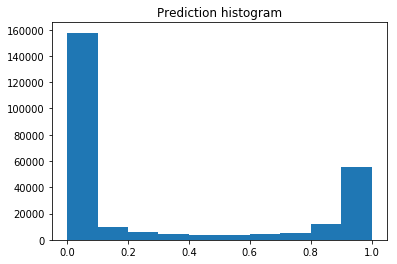

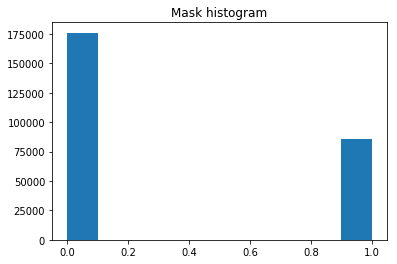

In [44]:
plt.hist(predictions[0].flatten())
plt.title("Prediction histogram")
plt.show()
plt.hist(y_test[0].flatten())
plt.title("Mask histogram")
plt.show()


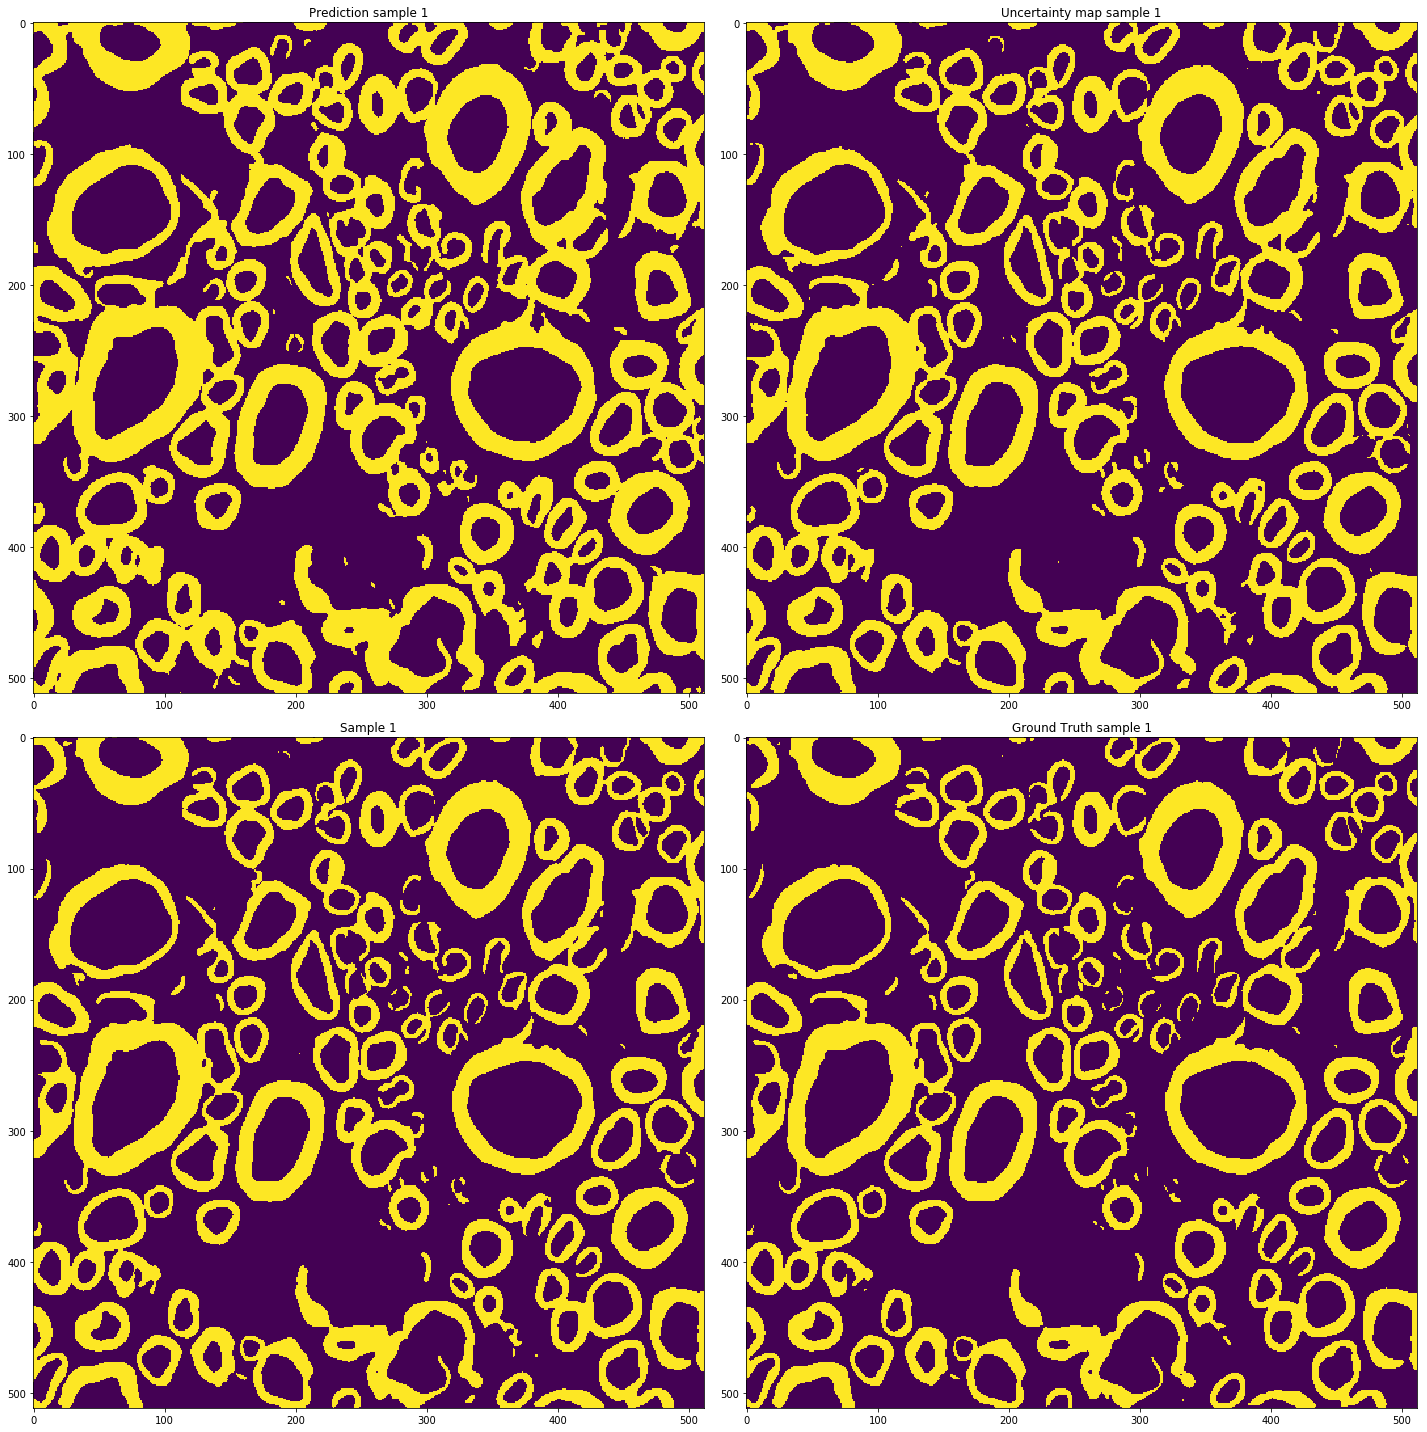

In [16]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(cv2.threshold(predictions[0][0, :, :], 0.2, 1, cv2.THRESH_BINARY)[1])
plt.title("Prediction sample 1")
plt.subplot(222)
plt.imshow(cv2.threshold(predictions[0][0, :, :], 0.4, 1, cv2.THRESH_BINARY)[1])
plt.title("Uncertainty map sample 1")
plt.subplot(223)
plt.imshow(cv2.threshold(predictions[0][0, :, :], 0.5, 1, cv2.THRESH_BINARY)[1])
plt.title("Sample 1")
plt.subplot(224)
plt.imshow(cv2.threshold(predictions[0][0, :, :], 0.6, 1, cv2.THRESH_BINARY)[1])
plt.title("Ground Truth sample 1")
plt.tight_layout()
plt.show()

In [55]:
# uncertainty computation

weights = final_weights_path
modelUncertain = unet_full_bn(dropout = True)
modelUncertain.load_weights(weights)

uncertain_map = []
uncertain = np.zeros(len(X_test))
accuracy = np.zeros(len(X_test))

print("Computing log predictions ...\n")
predictions = predict(X_test, model)

for i in range(len(X_test)):
    sample = X_test[i].reshape([1, 1, img_rows, img_cols])
    sample_prediction = cv2.threshold(predictions[i], 0.5, 1, cv2.THRESH_BINARY)[1].astype('uint8')
    accuracy[i] = compute_dice_coef(y_test[i][0], sample_prediction)
    uncertain[i] = compute_uncertain(sample, sample_prediction, modelUncertain)
    uncertain_map_i = compute_uncertain_map(sample, sample_prediction, modelUncertain)
    uncertain_map.append(uncertain_map_i)
    
    
uncertain_map_array = np.asarray(uncertain_map)
print(uncertain_map_array.shape)
print("Done")

Computing log predictions ...

(2, 512, 512)
Done


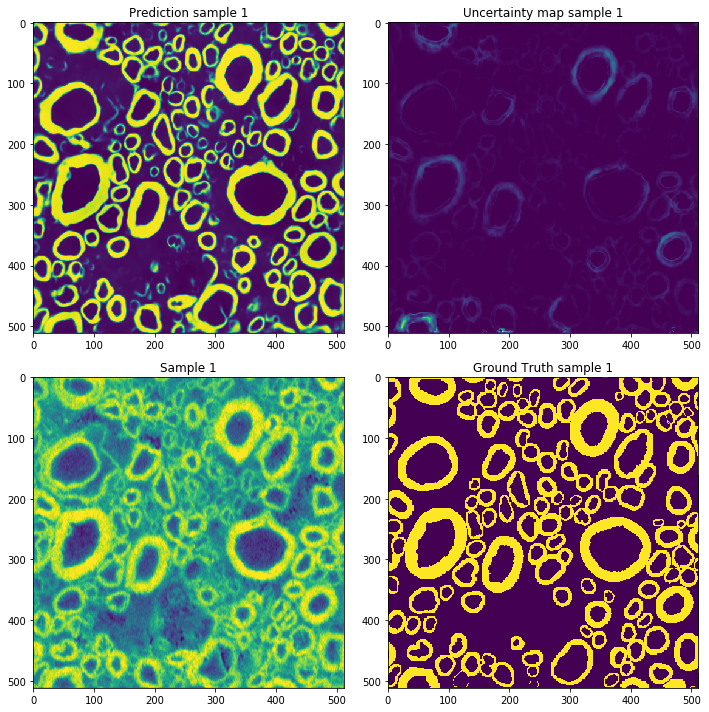

In [56]:
# Plot predictions and uncertainty map for 2 samples 

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(predictions[0][0,:,:])
plt.title("Prediction sample 1")
plt.subplot(222)
plt.imshow(uncertain_map_array[0])
plt.title("Uncertainty map sample 1")
plt.subplot(223)
plt.imshow(X_test[0][0,:,:])
plt.title("Sample 1")
plt.subplot(224)
plt.imshow(y_test[0][0,:,:])
plt.title("Ground Truth sample 1")
plt.tight_layout()
plt.show()

In [ ]:
X = np.load(path_mask_train)[0]
X.shape
plt.imshow(X[0, :, :], cmap = 'gray')
plt.show()
X

In [ ]:
np.min(X)

In [ ]:
X = np.load(path_mask_train)[0]
X.shape
plt.imshow(X[0, :, :], cmap = 'gray')
plt.show()
X

In [ ]:
np.min(X)

In [ ]:
X = np.load(path_mask_train)[0]
X.shape
plt.imshow(X[0, :, :], cmap = 'gray')
plt.show()
X

# From previous notebook

In [ ]:
## Predict and Compute Uncertainty Map

def predict(data, model):
    """
    Data prediction for a given model
    :param data: input data to predict.
    :param model: unet model.
    :return: predictions.
    """
    return model.predict(data, verbose=0)

def compute_dice_coef(y_true, y_pred):
    """
    Computes the Dice-Coefficient of a prediction given its ground truth.
    :param y_true: Ground truth.
    :param y_pred: Prediction.
    :return: Dice-Coefficient value.
    """
    smooth = 1.  # smoothing value to deal zero denominators.
    y_true_f = y_true.reshape([1, img_rows * img_cols])
    y_pred_f = y_pred.reshape([1, img_rows * img_cols])
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def compute_uncertain(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: overall uncertainty (not map) .
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return np.sum(var * transform)

    else:
        return np.sum(np.var(X, axis=0))

def compute_uncertain_map(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: uncertainty map.
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return var * transform

    else:
        return np.var(X, axis=0)  

# Predictions

print("Computing log predictions ...\n")
predictions = predict(X_test, model)
print(len(predictions))
sample_prediction = cv2.threshold(predictions[0], 0.5, 1, cv2.THRESH_BINARY)[1].astype('uint8')
sample_prediction.shape

plt.hist(predictions[0].flatten())
plt.title("Prediction histogram")
plt.show()
plt.hist(y_test[0].flatten())
plt.title("Mask histogram")
plt.show()


# uncertainty computation

weights = final_weights_path
modelUncertain = unet_full_bn(dropout = True)
modelUncertain.load_weights(weights)

uncertain_map = []
dice_coef_test = np.zeros(len(X_test))
dice = []

print("Computing log predictions ...\n")
predictions = predict(X_test, modelUncertain)

for threshold in np.arange(0.1, 1.1, 0.1):
    dice_coef_test = np.zeros(len(X_test))
    for i in range(len(X_test)):
        sample = X_test[i].reshape([1, 1, img_rows, img_cols])
        sample_prediction = cv2.threshold(predictions[i], threshold, 1, cv2.THRESH_BINARY)[1].astype('uint8')
        dice_coef_test[i] = compute_dice_coef(y_test[i][0], sample_prediction)
        uncertain_map_i = compute_uncertain_map(sample, sample_prediction, modelUncertain)
        uncertain_map.append(uncertain_map_i)
    dice.append(np.mean(dice_coef_test))


    
uncertain_map_array = np.asarray(uncertain_map)
print(uncertain_map_array.shape)
print("Done")

plt.plot(np.arange(0.1, 1.1, 0.1), dice, )
plt.ylabel("Dice Coeff")
plt.xlabel("Threshold value")
plt.grid()
plt.show()

# uncertainty computation

weights = final_weights_path
modelUncertain = unet_full_bn(dropout = True)
modelUncertain.load_weights(weights)

uncertain_map = []
uncertain = np.zeros(len(X_test))
dice = np.zeros(len(X_test))
jaccard = np.zeros(len(X_test))
accuracy = np.zeros(len(X_test))
sensitivity = np.zeros(len(X_test))
precision = np.zeros(len(X_test))
msde = np.zeros(len(X_test))
hde = np.zeros(len(X_test))

print("Computing log predictions ...\n")
predictions = predict(X_test, model)

for i in range(len(X_test)):
    sample = X_test[i].reshape([1, 1, img_rows, img_cols])
    sample_prediction = cv2.threshold(predictions[i], 0.7, 1, cv2.THRESH_BINARY)[1].astype('uint8')
    dice[i] = compute_dice_coef(y_test[i][0], sample_prediction)
    jaccard[i] = jaccard_score(sample_prediction, y_test[i][0, :, :])
    accuracy[i] = pixel_wise_accuracy(sample_prediction, y_test[i][0, :, :])
    sensitivity[i] = sensitivity_score(sample_prediction, y_test[i][0, :, :])
    precision[i] = precision_score(sample_prediction, y_test[i][0, :, :])
    msde[i] = msde_score(sample_prediction, y_test[i][0, :, :])
    hde[i] = hde_score(sample_prediction, y_test[i][0, :, :])
    uncertain[i] = compute_uncertain(sample, sample_prediction, modelUncertain)
    uncertain_map_i = compute_uncertain_map(sample, sample_prediction, modelUncertain)
    uncertain_map.append(uncertain_map_i)
    
    
uncertain_map_array = np.asarray(uncertain_map)
print(uncertain_map_array.shape)
print("Done")

# Plot predictions and uncertainty map for 2 samples 

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(predictions[0][0,:,:])
plt.title("Prediction sample 1")
plt.subplot(222)
plt.imshow(uncertain_map_array[0])
plt.title("Uncertainty map sample 1")
plt.subplot(223)
plt.imshow(X_test[0][0,:,:])
plt.title("Sample 1")
plt.subplot(224)
plt.imshow(y_test[0][0,:,:])
plt.title("Ground Truth sample 1")
plt.tight_layout()
plt.show()

## Score measure

def jaccard_score(seg, gt):
    intersection = (seg*gt).sum()
    union = seg.sum()+gt.sum()-intersection
    if union == 0:
        return 1.
    else:
        return float(intersection)/union
    
def pixel_wise_accuracy(y_true, y_pred):
    y_true_f = y_true.reshape([1, img_rows * img_cols])
    y_pred_f = y_pred.reshape([1, img_rows * img_cols])
    return 1 - np.count_nonzero(y_pred_f - y_true_f) / y_true_f.shape[1]
    

def distances(pred, gt):
    d1 = morphology.distance_transform_edt(1-gt)*pred
    d2 = morphology.distance_transform_edt(1-pred)*gt
    return d1, d2


# distance to the closest class / between the most distant class / applicable for myellin since not convex ?
def msde_score(pred, gt):
    d1, d2 = distances(pred, gt)
    return 0.5*(np.mean(d1)/np.sum(pred)+np.mean(d2)/np.sum(gt))*pred.shape[0]*pred.shape[1]

def hde_score(pred, gt):
    d1, d2 = distances(pred, gt)
    return max(np.max(d1), np.max(d2)) /724



def numeric_score(y_pred, y_true):
    y_pred = y_pred.astype(int)
    y_true = y_true.astype(int)
    FP = float(np.sum((y_pred == 1) & (y_true == 0)))
    FN = float(np.sum((y_pred == 0) & (y_true == 1)))
    TP = float(np.sum((y_pred == 1) & (y_true == 1)))
    TN = float(np.sum((y_pred == 0) & (y_true == 0)))
    return FP, FN, TP, TN

def precision_score(y_pred, y_true):
    # PPV
    FP, FN, TP, TN = numeric_score(y_pred, y_true)
    if (TP + FP) <= 0:
        return 0.
    else:
        return np.divide(TP, TP + FP) 
    

def sensitivity_score(y_pred, y_true):
    # TPR, sensitivity
    FP, FN, TP, TN = numeric_score(y_pred, y_true)
    if (TP + FN) <= 0:
        return 0.
    else:
        return np.divide(TP, TP + FN) 


metrics_array_1 = np.array([np.mean(dice), np.mean(jaccard), np.mean(accuracy), np.mean(precision), np.mean(sensitivity)])

metrics_array_2 = np.array([np.mean(dice), np.mean(jaccard), np.mean(accuracy), np.mean(precision), np.mean(sensitivity)])

metrics_array_3 = np.array([np.mean(dice), np.mean(jaccard), np.mean(accuracy), np.mean(precision), np.mean(sensitivity)])





n_groups = 5
fig, ax = plt.subplots()
index = np.arange(n_groups)

rects1 = plt.bar(index-0.1, metrics_array_1, width=0.2, color='green',label='model1')
rects2 = plt.bar(index+0.1, metrics_array_2, width=0.2, color='red',label='model2')
#rects3 = plt.bar(index+0.3, metrics_array_3, width=0.2, color='blue',label='model3')

plt.ylabel('Values')
plt.title('Pixelwise segmentation metrics for myelin')
plt.xticks(index, ('Dice', 'Jaccard', 'Accuracy', 'Precision', 'Sensitivity'),fontsize=10)
plt.legend(loc='best')
plt.grid(True)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

## Rank the most uncertain predictions

def to_be_annotated(uncertain, n):
    """Return index of the most n uncertain predictions"""
    return np.flip(np.argsort(uncertain), 0)[:n]

def add_annotated_sample(original, added, added_index):
    """append the annotated samples to the training set"""
    return np.vstack((original, added[added_index] ))


def remove_annotated(original, added_index):
    """remove annotated samples from unlabelled dataset"""
    new_index = np.delete(np.arange(len(original)), added_index)
    return original[new_index]

index = to_be_annotated(uncertain, 3)
new_X_train = add_annotated_sample(new_X_train, new_X_test, index)
new_y_train = add_annotated_sample(new_y_train, new_y_test, index)

new_X_test = remove_annotated(new_X_test, index)
new_y_test = remove_annotated(new_y_test, index)

print(new_X_train.shape, new_y_train.shape)
print(new_X_test.shape, new_y_test.shape)

## Retrain with new dataset

# data augmentation
seed = 1

train_img_generator = data_generator().flow(new_X_train, seed = seed, batch_size = batch_size,  shuffle=False)
train_mask_generator = data_generator().flow(new_y_train, seed = seed, batch_size = batch_size, shuffle=False)

train_generator = zip(train_img_generator, train_mask_generator)

model = unet_full_bn(dropout = True)
reset_weights(model)
print(model.summary())

model_checkpoint = ModelCheckpoint(initial_weights_path, monitor='loss', save_best_only = True)


# if Data Augmentation
if apply_augmentation:
    timestamp = format(time.strftime('%m%d_%H%M_%S'))
    save_parameters(format(time.strftime('%m%d_%H%M_%S')), get_params())
    tensorboard = TensorBoard(log_dir = str("../logs/" + str(timestamp)))
    history = model.fit_generator(train_generator, 
                                  validation_data = (X_valid, y_valid),
                                  epochs = nb_initial_epochs, 
                                  verbose = 1,
                                  shuffle = True,
                                  steps_per_epoch = steps_per_epoch, 
                                  #validation_steps= 5,
                                  callbacks = [tensorboard])
    model.save(final_weights_path)

    
# if No Data Augmentation
else:
    timestamp = format(time.strftime('%m%d_%H%M_%S'))
    save_parameters(format(time.strftime('%m%d_%H%M_%S')), get_params())
    tensorboard = TensorBoard(log_dir = str("../logs/" + str(timestamp)))
    history = model.fit(X_train, y_train, validation_data = (X_valid, y_valid),
                            batch_size = batch_size, 
                            epochs = nb_initial_epochs,
                            verbose = 1, 
                            shuffle = True, 
                            callbacks = [tensorboard])
    model.save(final_weights_path)

# uncertainty computation

weights = final_weights_path
modelUncertain = unet_full_bn(dropout = True)
modelUncertain.load_weights(weights)

uncertain_map = []
uncertain = np.zeros(len(X_test))
dice = np.zeros(len(X_test))
jaccard = np.zeros(len(X_test))
accuracy = np.zeros(len(X_test))
sensitivity = np.zeros(len(X_test))
precision = np.zeros(len(X_test))
msde = np.zeros(len(X_test))
hde = np.zeros(len(X_test))

print("Computing log predictions ...\n")
predictions = predict(X_test, model)

for i in range(len(X_test)):
    sample = X_test[i].reshape([1, 1, img_rows, img_cols])
    sample_prediction = cv2.threshold(predictions[i], 0.7, 1, cv2.THRESH_BINARY)[1].astype('uint8')
    dice[i] = compute_dice_coef(y_test[i][0], sample_prediction)
    jaccard[i] = jaccard_score(sample_prediction, y_test[i][0, :, :])
    accuracy[i] = pixel_wise_accuracy(sample_prediction, y_test[i][0, :, :])
    sensitivity[i] = sensitivity_score(sample_prediction, y_test[i][0, :, :])
    precision[i] = precision_score(sample_prediction, y_test[i][0, :, :])
    msde[i] = msde_score(sample_prediction, y_test[i][0, :, :])
    hde[i] = hde_score(sample_prediction, y_test[i][0, :, :])
    uncertain[i] = compute_uncertain(sample, sample_prediction, modelUncertain)
    uncertain_map_i = compute_uncertain_map(sample, sample_prediction, modelUncertain)
    uncertain_map.append(uncertain_map_i)
    
    
uncertain_map_array = np.asarray(uncertain_map)
print(uncertain_map_array.shape)
print("Done")